# Stock Price Prediction: SPY Next-Day Opening Price
## Market Sentiment Analysis Using Financial News Headlines

**Project Goal:** Predict the next day's opening price of SPY (S&P 500 ETF) using:
- Historical price and volume data from yFinance
- Financial news headlines from multiple sources (CNBC, Reuters, The Guardian)
- Technical indicators and sentiment analysis

**Workflow Overview:**
1. **Data Collection**: Download SPY price data and financial news headlines
2. **Exploratory Data Analysis**: Understand price patterns and market behavior
3. **Feature Engineering**: Create technical indicators, calendar features, and price momentum signals
4. **News Processing**: Clean and aggregate daily news headlines
5. **Sentiment Analysis**: Extract sentiment scores using VADER and FinBERT
6. **Data Merging**: Combine all features into a single modeling dataset
7. **Final Dataset**: Export clean dataset ready for machine learning

## 📚 Glossary of Key Terms

**Stock Market Terms:**
- **SPY**: SPDR S&P 500 ETF Trust - an exchange-traded fund that tracks the S&P 500 stock market index
- **Opening Price**: The price at which a stock first trades when the market opens
- **Closing Price**: The final price at which a stock trades when the market closes
- **Trading Volume**: The total number of shares traded during a specific period
- **Return**: The percentage change in price over a time period

**Technical Indicators:**
- **Moving Average (MA)**: Average price over a specific number of days; smooths out short-term fluctuations
- **Volatility**: A measure of how much price fluctuates; higher volatility = larger price swings
- **ATR (Average True Range)**: Measures market volatility by showing the average price range over a period
- **Momentum**: The rate of price change over time; indicates if prices are accelerating up or down
- **True Range (TR)**: The greatest of: (high-low), (high-previous close), or (low-previous close)

**Feature Engineering Terms:**
- **Lag Features**: Previous values (e.g., yesterday's return) used to predict future values
- **Rolling Window**: A calculation that moves through the data (e.g., 20-day rolling average)
- **Intraday**: Occurring within a single trading day
- **Overnight Return**: Price change from previous close to today's open

**Machine Learning Terms:**
- **Feature**: An input variable used to make predictions (e.g., previous day's closing price)
- **Target Variable**: What we're trying to predict (Next_Open_SPY)
- **Feature Engineering**: Creating new useful features from raw data

**Natural Language Processing (NLP) Terms:**
- **Sentiment Analysis**: Determining if text expresses positive, negative, or neutral emotion
- **VADER**: Valence Aware Dictionary and sEntiment Reasoner - a rule-based sentiment tool
- **FinBERT**: A machine learning model trained specifically on financial text
- **Tokenization**: Breaking text into smaller pieces (words or subwords) for analysis
- **Compound Score**: VADER's overall sentiment score ranging from -1 (very negative) to +1 (very positive)

**Data Processing Terms:**
- **Business Day**: A weekday when markets are open (excludes weekends and holidays)
- **Aggregation**: Combining multiple data points into a summary (e.g., all daily headlines into one string)
- **Normalization**: Standardizing data format for consistency
- **Merge/Join**: Combining two datasets based on a common column (e.g., date)

---

# Part 1: Setup and Installation

## Install Required Libraries

In [4]:
# Install all required packages
!pip install yfinance --upgrade --no-cache-dir
!pip install contractions --quiet
!pip install vaderSentiment --quiet
!pip install transformers --quiet

## Import Libraries

In [1]:
# First, install the missing package
!pip install torch
# Standard data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from dateutil import parser

# Financial data
import yfinance as yf

# Date handling for business days and holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Text processing
import contractions
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Kaggle datasets
import kagglehub

---

# Part 2: Stock Price Data Collection and Exploration

## Download SPY Price Data from yFinance

In [2]:
# Download SPY (S&P 500 ETF) historical data
# Date range: December 30, 2017 to July 19, 2020 (matches news dataset availability)
df = yf.download("SPY", start="2017-12-30", end="2020-07-19")

# Display first few rows to verify data
df.head()

# Keep a copy of the original data for later use
original = df.copy()

C:\Users\Owner\AppData\Local\Temp\ipykernel_19512\339138222.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", start="2017-12-30", end="2020-07-19")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Verify Data Completeness

In [3]:
# Calculate expected number of trading days (excluding weekends and federal holidays)
start_date = df.index.min()
end_date = df.index.max()

# Create a custom business day calendar that accounts for US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
num_business_days = len(pd.date_range(start=start_date, end=end_date, freq=us_bd))

# Compare actual data rows with expected trading days
print(f"Number of rows in the data: {df.shape[0]}")
print(f"Number of business days between {start_date.date()} and {end_date.date()}: {num_business_days}")
print("\nDate range in the data:")
print(f"Start date: {start_date.date()}")
print(f"End date: {end_date.date()}")

Number of rows in the data: 640
Number of business days between 2018-01-02 and 2020-07-17: 640

Date range in the data:
Start date: 2018-01-02
End date: 2020-07-17


In [4]:
# Check for missing values in the dataset
df.isnull().sum()

Price   Ticker
Close   SPY       0
High    SPY       0
Low     SPY       0
Open    SPY       0
Volume  SPY       0
dtype: int64

---

## Exploratory Data Analysis (EDA)

Understanding price patterns and market behavior helps us design better features for prediction.

### 1. Opening Price Trends Over Time

Visualizing the opening price helps identify overall market trends, crashes, and recoveries.

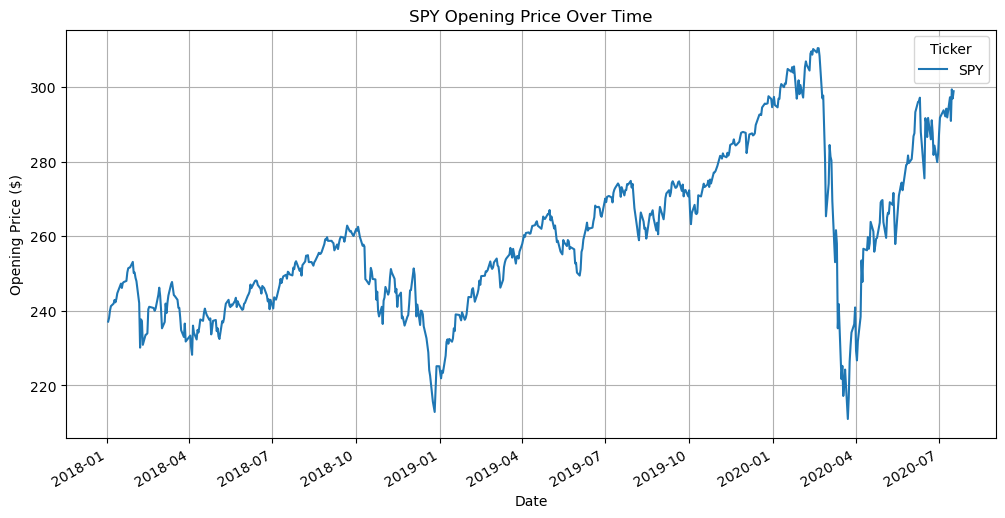

In [5]:
# Plot opening price over time
df['Open'].plot(figsize=(12, 6), title='SPY Opening Price Over Time')
plt.xlabel('Date')
plt.ylabel('Opening Price ($)')
plt.grid(True)
plt.show()

**Key Observations:**
- SPY shows a general upward trend from ~$240 to ~$300 over the period
- Sharp decline in early 2020 reflects the COVID-19 market crash
- Strong recovery follows the crash, showing market resilience

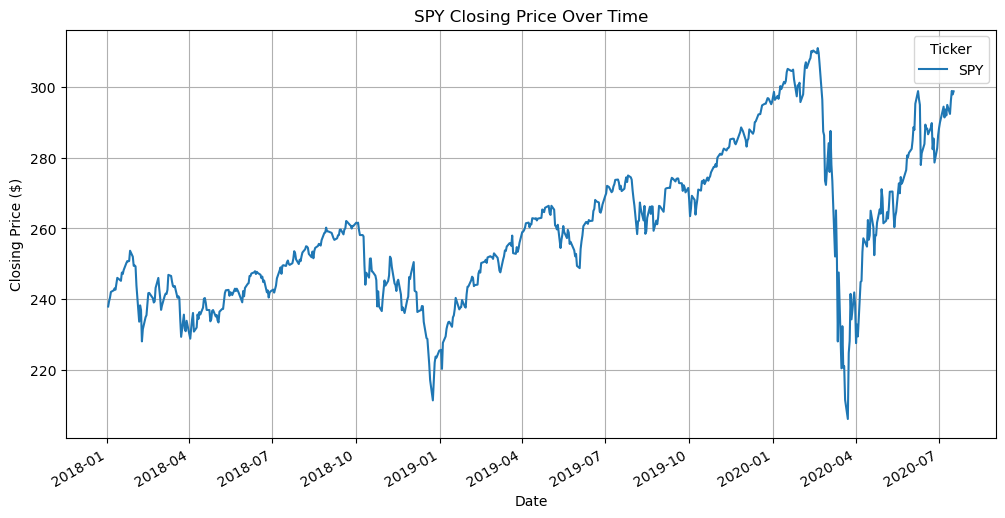

In [6]:
# Plot closing price for comparison
df['Close'].plot(figsize=(12, 6), title='SPY Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

**Key Observations:**
- Closing price follows the same pattern as opening price (as expected)
- We'll use closing price as the primary feature since it captures the final market consensus each day

### 2. Daily Returns Analysis

Daily returns show the percentage change from one day to the next, revealing volatility patterns.

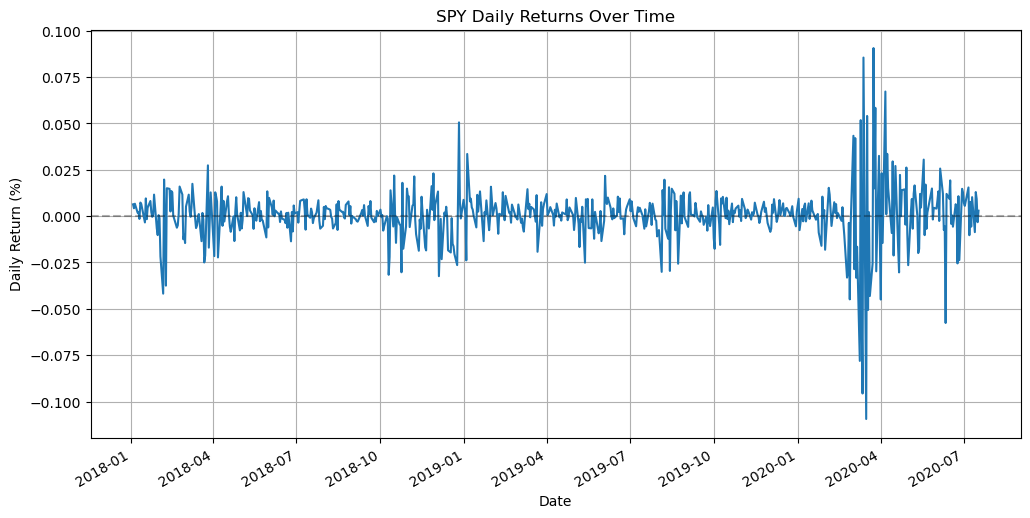

In [7]:
# Calculate daily returns (percentage change in closing price)
df['Return'] = df['Close'].pct_change()

# Visualize returns over time
df['Return'].plot(figsize=(12, 6), title='SPY Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)  # Add zero line for reference
plt.grid(True)
plt.show()

**Key Observations:**
- Most daily returns are small, typically within -1% to +1%
- Extreme spikes occur during major market events (COVID-19 crash)
- Volatility (price fluctuation) is not constant over time
- Small daily movements may be difficult to predict from news headlines alone

### 3. Distribution of Daily Returns

Understanding the distribution helps us see how common different return magnitudes are.

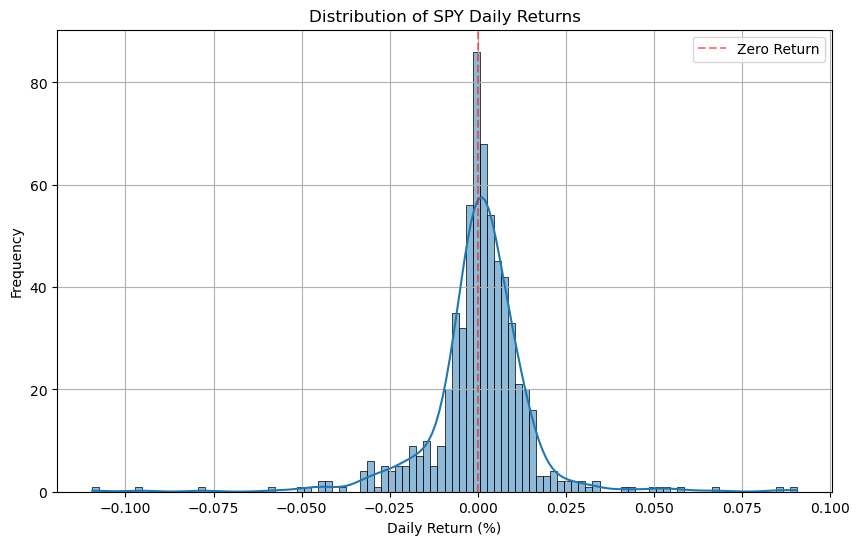

In [8]:
# Create histogram of returns with density curve
plt.figure(figsize=(10, 6))
sns.histplot(df['Return'].dropna(), bins=100, kde=True)
plt.title("Distribution of SPY Daily Returns")
plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Zero Return')
plt.grid(True)
plt.legend()
plt.show()

**Key Observations:**
- Distribution is approximately normal (bell-shaped) and centered near zero
- Small movements (near 0%) are very common
- The distribution has "fat tails" - extreme events are rarer but do occur

### 4. Volatility Analysis

Volatility measures how much returns fluctuate over time. Higher volatility = more uncertainty.

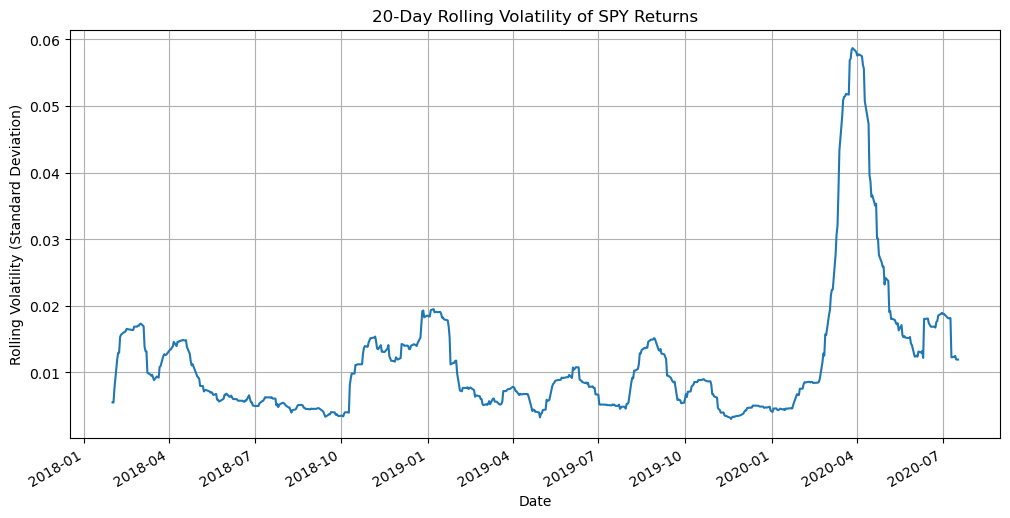

In [9]:
# Calculate 20-day rolling volatility (standard deviation of returns)
df['Volatility_20'] = df['Return'].rolling(20).std()

# Visualize volatility over time
plt.figure(figsize=(12, 6))
df['Volatility_20'].plot()
plt.title('20-Day Rolling Volatility of SPY Returns')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility (Standard Deviation)')
plt.grid(True)
plt.show()

**Key Observations:**
- Volatility is generally low and stable outside of crisis periods
- Dramatic spike in volatility during the COVID-19 crash (March 2020)
- Volatility gradually decreases after the crash as markets stabilize

### 5. Extreme Market Events

Identifying the biggest gains and losses helps understand how news impacts prices.

In [10]:
# Find the 10 worst (most negative) return days
worst = df.nsmallest(10, 'Return')[['Return']]
print("10 Largest Market Drops:")
worst

10 Largest Market Drops:


Price,Return
Ticker,
Date,
2020-03-16,-0.109424
2020-03-12,-0.095677
2020-03-09,-0.078095
2020-06-11,-0.057649
2020-03-18,-0.050633
2020-03-11,-0.048749
2020-04-01,-0.045005
2020-02-27,-0.044911


In [11]:
# Find the 10 best (most positive) return days
best = df.nlargest(10, 'Return')[['Return']]
print("10 Largest Market Gains:")
best

10 Largest Market Gains:


Price,Return
Ticker,
Date,
2020-03-24,0.090603
2020-03-13,0.085486
2020-04-06,0.067166
2020-03-26,0.058390
2020-03-17,0.053992
2020-03-10,0.051745
2018-12-26,0.050525
2020-03-02,0.043307


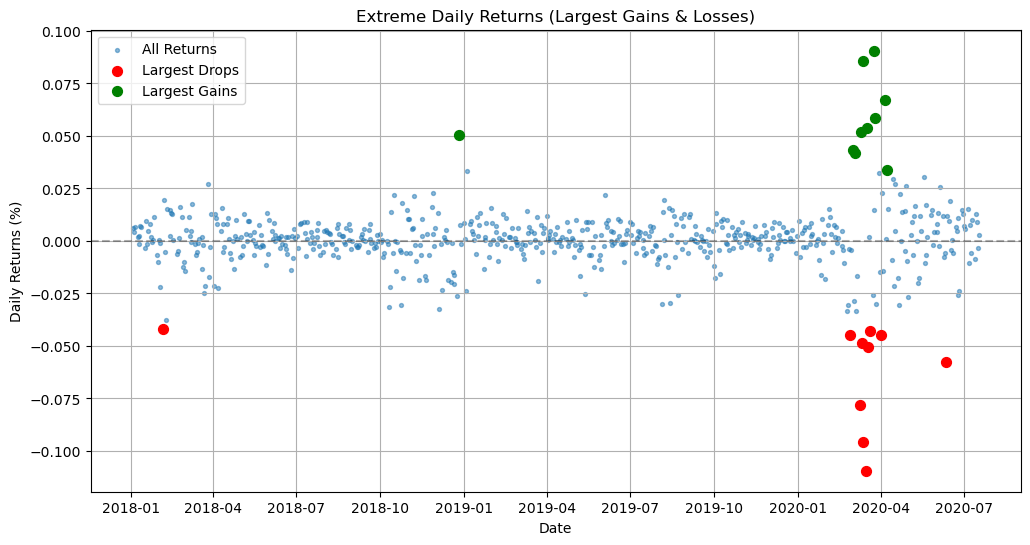

In [12]:
# Visualize all returns with extreme events highlighted
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Return'], s=8, alpha=0.5, label='All Returns')
plt.scatter(worst.index, worst['Return'], color='red', s=50, label='Largest Drops', zorder=5)
plt.scatter(best.index, best['Return'], color='green', s=50, label='Largest Gains', zorder=5)
plt.title("Extreme Daily Returns (Largest Gains & Losses)")
plt.xlabel("Date")
plt.ylabel("Daily Returns (%)")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

---

## 🎨 Enhanced Interactive Visualizations (Prisca UI Preview)

The following cells demonstrate the new interactive visualizations designed for the Prisca dashboard.

In [ ]:
# Install plotly for interactive visualizations
!pip install plotly kaleido networkx --quiet

In [ ]:
# Import enhanced visualization module
from enhanced_visualizations import PriscaVisualizations

# Initialize with dark theme (perfect for Prisca dashboard)
viz = PriscaVisualizations(theme='dark')

print("✓ Enhanced visualization module loaded")
print("  Available: Interactive candlestick, sentiment charts, confidence gauges, and more")

### Interactive Candlestick Chart with Volume

This chart will be the centerpiece of the Prisca dashboard - showing price movements with predictions overlay.

In [ ]:
# Create interactive candlestick chart
# Select last 90 days for better visualization
recent_data = price_df.tail(90).copy()

# Create the chart
fig = viz.price_trend_interactive(recent_data)

# Display (interactive in Jupyter, static image when exported)
fig.show()

print(f"✓ Chart generated for {len(recent_data)} trading days")
print("  Features: Zoom, pan, crosshair, hover tooltips")

### Volatility Heatmap

Visualize market volatility patterns over time - helps identify high-risk periods.

In [ ]:
# Create volatility heatmap
fig_vol = viz.volatility_heatmap(price_df, window=20)
fig_vol.show()

print("✓ Volatility heatmap generated")
print("  Bubble size = volatility magnitude")

**Key Observations:**
- Largest negative returns (drops of -5% to -11%) cluster in March/April 2020 during COVID crash
- Largest positive returns (gains of +5% to +9%) also occur in early 2020 during recovery
- One notable drop (~-4.5%) in early 2018, but pre-2020 extremes are much smaller
- **Fat-tailed distribution**: Major news events drive the biggest market movements
- This suggests news sentiment may be most predictive during high-volatility periods

---

# Part 3: Feature Engineering for Price Prediction

Creating informative features from raw price data to help predict next-day opening prices.

In [13]:
# Start with the original yFinance data
# Extract basic price columns (removing multiindex if present)
base_cols = [c for c in ["Close", "High", "Low", "Open", "Volume"] if c in original.columns]
price_df = original[base_cols].copy()

In [14]:
# Handle multiindex columns if they exist (yFinance sometimes creates these)
if isinstance(price_df.columns, pd.MultiIndex):
    price_df.columns = [
        "_".join([str(c) for c in col if c])
        for col in price_df.columns.to_flat_index()
    ]

# Remove any duplicate columns
price_df = price_df.loc[:, ~price_df.columns.duplicated()]

In [15]:
## FEATURE ENGINEERING
## We'll create multiple categories of features to capture different market dynamics

# ===== 1. RENAME COLUMNS FOR CLARITY =====
price_df = price_df.rename(columns={
    "Close":  "Close_SPY",
    "High":   "High_SPY",
    "Low":    "Low_SPY",
    "Open":   "Open_SPY",
    "Volume": "Volume_SPY",
})

# ===== 2. BASIC RETURN =====
# Daily percentage change in closing price
if "Return" not in price_df.columns:
    price_df["Return"] = price_df["Close_SPY"].pct_change()

# ===== 3. INTRADAY PRICE STRUCTURE =====
# These capture how price moved within the trading day
price_df["High_Low_Spread"]   = price_df["High_SPY"] - price_df["Low_SPY"]  # Trading range
price_df["Close_Open_Change"] = price_df["Close_SPY"] - price_df["Open_SPY"]  # Intraday change
price_df["Close_to_High"]     = price_df["High_SPY"] - price_df["Close_SPY"]  # Distance to high
price_df["Close_to_Low"]      = price_df["Close_SPY"] - price_df["Low_SPY"]  # Distance to low

# ===== 4. RETURNS, LAGS & MOMENTUM =====
# Historical returns help capture recent trends
price_df["Return_1"] = price_df["Return"].shift(1)  # Yesterday's return
price_df["Return_2"] = price_df["Return"].shift(2)  # 2 days ago
price_df["Return_3"] = price_df["Return"].shift(3)  # 3 days ago

# Multi-day returns
price_df["Return_5"]  = price_df["Close_SPY"].pct_change(5)   # 5-day return
price_df["Return_10"] = price_df["Close_SPY"].pct_change(10)  # 10-day return

# Momentum: measures rate of price acceleration
price_df["Momentum_3"] = price_df["Close_SPY"] / price_df["Close_SPY"].shift(3) - 1
price_df["Momentum_7"] = price_df["Close_SPY"] / price_df["Close_SPY"].shift(7) - 1

# Lagged closing prices
price_df["Close_lag1"] = price_df["Close_SPY"].shift(1)
price_df["Close_lag2"] = price_df["Close_SPY"].shift(2)
price_df["Close_lag3"] = price_df["Close_SPY"].shift(3)

# ===== 5. MOVING AVERAGES (TREND INDICATORS) =====
# Smooth out short-term fluctuations to reveal trends
price_df["MA_5"]  = price_df["Close_SPY"].rolling(5).mean()   # 5-day moving average
price_df["MA_20"] = price_df["Close_SPY"].rolling(20).mean()  # 20-day moving average

# Distance from moving averages (indicates overbought/oversold conditions)
price_df["Close_minus_MA_5"]  = price_df["Close_SPY"] - price_df["MA_5"]
price_df["Close_minus_MA_20"] = price_df["Close_SPY"] - price_df["MA_20"]

# ===== 6. VOLATILITY (RISK MEASURES) =====
# Standard deviation of returns over different windows
price_df["Volatility_5"]  = price_df["Return"].rolling(5).std()
price_df["Volatility_10"] = price_df["Return"].rolling(10).std()
if "Volatility_20" not in price_df.columns:
    price_df["Volatility_20"] = price_df["Return"].rolling(20).std()

# ===== 7. AVERAGE TRUE RANGE (ATR) =====
# ATR measures volatility considering gaps between days
price_df["TR"] = price_df.apply(
    lambda row: max(
        row["High_SPY"] - row["Low_SPY"],           # Today's range
        abs(row["High_SPY"] - row["Close_SPY"]),    # Gap up from previous close
        abs(row["Low_SPY"] - row["Close_SPY"])      # Gap down from previous close
    ),
    axis=1
)
price_df["ATR_14"] = price_df["TR"].rolling(14).mean()  # 14-day average true range

# ===== 8. OVERNIGHT / GAP BEHAVIOR =====
# Captures price movement between yesterday's close and today's open
price_df["Prev_Day_Overnight_Return"] = (
    price_df["Open_SPY"] / price_df["Close_SPY"].shift(1) - 1
)

# ===== 9. CALENDAR / SEASONALITY FEATURES =====
# Market behavior can vary by day of week, month, etc.
price_df["day_of_week"]    = price_df.index.dayofweek        # 0=Monday, 4=Friday
price_df["month"]          = price_df.index.month            # 1-12
price_df["day_of_month"]   = price_df.index.day              # 1-31
price_df["week_of_month"]  = (price_df.index.day - 1) // 7  # 0-4
price_df["is_month_end"]   = price_df.index.is_month_end.astype(int)    # Binary flag
price_df["is_quarter_end"] = price_df.index.is_quarter_end.astype(int)  # Binary flag

# ===== 10. TARGET VARIABLE =====
# What we're trying to predict: tomorrow's opening price
price_df["Next_Open_SPY"] = price_df["Open_SPY"].shift(-1)

print(f"Created {len(price_df.columns)} features from raw price data")

Created 37 features from raw price data


In [ ]:
# Display information about the engineered features
print("Feature Engineering Complete!")
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 640 entries, 2018-01-02 to 2020-07-17
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Close_SPY                  640 non-null    float64
 1   High_SPY                   640 non-null    float64
 2   Low_SPY                    640 non-null    float64
 3   Open_SPY                   640 non-null    float64
 4   Volume_SPY                 640 non-null    int64  
 5   Return                     639 non-null    float64
 6   High_Low_Spread            640 non-null    float64
 7   Close_Open_Change          640 non-null    float64
 8   Close_to_High              640 non-null    float64
 9   Close_to_Low               640 non-null    float64
 10  Return_1                   638 non-null    float64
 11  Return_2                   637 non-null    float64
 12  Return_3                   636 non-null    float64
 13  Return_5                   635 

In [ ]:
# Check for missing values (expected in early rows due to rolling windows and lags)
missing_summary = price_df.isna().sum()
print("Missing values per feature:")
print(missing_summary[missing_summary > 0])

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return,1
High_Low_Spread,0
Close_Open_Change,0
Close_to_High,0
Close_to_Low,0


---

# Part 4: Financial News Headlines Data

## Download News Headlines from Kaggle

In [16]:
# Download financial news headlines dataset from Kaggle
# Contains headlines from CNBC, The Guardian, and Reuters
path = kagglehub.dataset_download("notlucasp/financial-news-headlines")
print(f"Dataset downloaded to: {path}")

100%|██████████| 3.91M/3.91M [00:00<00:00, 9.04MB/s]

Extracting files...
Dataset downloaded to: C:\Users\Owner\.cache\kagglehub\datasets\notlucasp\financial-news-headlines\versions\2
Dataset downloaded to: C:\Users\Owner\.cache\kagglehub\datasets\notlucasp\financial-news-headlines\versions\2


In [17]:
# Load news data from all three sources
cnbc = pd.read_csv(path + "/cnbc_headlines.csv")
guardian = pd.read_csv(path + "/guardian_headlines.csv")
reuters = pd.read_csv(path + "/reuters_headlines.csv")

# Convert to DataFrames (redundant but kept for clarity)
cnbc_df = pd.DataFrame(cnbc)
guardian_df = pd.DataFrame(guardian)
reuters_df = pd.DataFrame(reuters)

print(f"CNBC: {len(cnbc_df)} headlines")
print(f"Guardian: {len(guardian_df)} headlines")
print(f"Reuters: {len(reuters_df)} headlines")

CNBC: 3080 headlines
Guardian: 17800 headlines
Reuters: 32770 headlines


## Inspect News Data Structure

In [18]:
# Examine CNBC data structure
print("CNBC DataFrame Structure:")
cnbc_df.info()

CNBC DataFrame Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    2800 non-null   object
 1   Time         2800 non-null   object
 2   Description  2800 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


In [ ]:
# Examine Guardian data structure
print("Guardian DataFrame Structure:")
guardian_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17800 entries, 0 to 17799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       17800 non-null  object
 1   Headlines  17800 non-null  object
dtypes: object(2)
memory usage: 278.3+ KB


In [ ]:
# Examine Reuters data structure
print("Reuters DataFrame Structure:")
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


**Data Quality Decision:**
- Guardian dataset lacks a "Description" field (only has headlines)
- For consistency across all sources and to avoid introducing bias from variable-length text, we'll use **only headlines** from all three sources
- Headlines are concise and high-signal, making them ideal for sentiment analysis

## Standardize Column Names and Add Source Labels

In [19]:
# Rename headline columns to a consistent name
cnbc_df = cnbc_df.rename(columns={'Headlines': 'headline'})
guardian_df = guardian_df.rename(columns={'Headlines': 'headline'})
reuters_df = reuters_df.rename(columns={'Headlines': 'headline'})

# Add source label to each dataset (useful for tracking and debugging)
cnbc_df['source'] = 'cnbc'
guardian_df['source'] = 'guardian'
reuters_df['source'] = 'reuters'

print("Column names standardized and source labels added")

Column names standardized and source labels added


## Parse and Normalize Dates

Each news source has a different date format that needs to be converted to a standard datetime format.

In [20]:
# Parse Guardian dates (format: "01-Jan-20")
guardian_df['date'] = pd.to_datetime(guardian_df['Time'], format="%d-%b-%y", errors='coerce')

# Parse Reuters dates (format: "Jan 01 2020")
reuters_df['date'] = pd.to_datetime(reuters_df['Time'], format="%b %d %Y", errors='coerce')

print("Guardian and Reuters dates parsed successfully")

Guardian and Reuters dates parsed successfully


In [21]:
# CNBC has a more complex format that requires custom parsing
# Format example: "Published Tue, Jan 1 2019 9:00 AM EST"

def parse_cnbc_time(time_str):
    """Extract date from CNBC's time format"""
    if pd.isna(time_str):
        return None
    # Use regex to extract the date portion after the comma
    match = re.search(r",\s*(.*)", time_str)
    if match:
        date_str = match.group(1)
        try:
            return parser.parse(date_str)
        except:
            return None
    return None

cnbc_df['date'] = cnbc_df['Time'].apply(parse_cnbc_time)
print("CNBC dates parsed successfully")

CNBC dates parsed successfully


## Handle Missing Dates and Clean Data

In [22]:
# Check how many dates failed to parse
print("Missing dates after parsing:")
print(f"CNBC: {cnbc_df['date'].isna().sum()}")
print(f"Guardian: {guardian_df['date'].isna().sum()}")
print(f"Reuters: {reuters_df['date'].isna().sum()}")

Missing dates after parsing:
CNBC: 280
Guardian: 40
Reuters: 0


In [23]:
# Remove rows with missing headlines or dates (can't use them for analysis)
cnbc_df = cnbc_df.dropna(subset=['headline', 'date'])
guardian_df = guardian_df.dropna(subset=['headline', 'date'])
reuters_df = reuters_df.dropna(subset=['headline', 'date'])

print(f"\nAfter cleaning:")
print(f"CNBC: {len(cnbc_df)} headlines")
print(f"Guardian: {len(guardian_df)} headlines")
print(f"Reuters: {len(reuters_df)} headlines")


After cleaning:
CNBC: 2800 headlines
Guardian: 17760 headlines
Reuters: 32770 headlines


## Combine All News Sources

In [24]:
# Concatenate all three news sources into a single DataFrame
news_all = pd.concat([
    cnbc_df[['headline', 'date', 'source']],
    guardian_df[['headline', 'date', 'source']],
    reuters_df[['headline', 'date', 'source']]
], ignore_index=True)

print(f"Combined dataset: {len(news_all)} total headlines from {news_all['date'].min()} to {news_all['date'].max()}")

Combined dataset: 53330 total headlines from 2017-12-17 00:00:00 to 2020-07-18 00:00:00


In [ ]:
# Verify data quality
print("Missing values in combined dataset:")
news_all.isna().sum()

,0
headline,0
date,0
source,0


## Clean and Normalize Headlines

Text cleaning ensures consistent formatting and removes noise that could confuse sentiment models.

**Cleaning steps:**
1. Expand contractions (e.g., "don't" → "do not")
2. Convert to lowercase for consistency
3. Remove URLs
4. Remove line breaks and special characters
5. Collapse multiple spaces

In [25]:
def clean_headline(text):
    """
    Clean and normalize headline text for sentiment analysis
    
    Args:
        text: Raw headline string
    
    Returns:
        Cleaned headline string
    """
    if pd.isna(text):
        return ""

    # Expand contractions (don't → do not, can't → cannot)
    text = contractions.fix(text)
    
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # Remove line breaks and tabs
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")

    # Keep only letters, numbers, and basic punctuation
    text = re.sub(r"[^a-z0-9.,%$?!\- ]", " ", text)

    # Collapse multiple spaces into single space
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply cleaning function to all headlines
news_all['headline_clean'] = news_all['headline'].astype(str).apply(clean_headline)

# Remove headlines that became empty after cleaning
news_all = news_all[news_all['headline_clean'].str.len() > 0].copy()

print(f"Headlines cleaned. {len(news_all)} headlines remaining.")

Headlines cleaned. 53330 headlines remaining.


### Verify Text Cleaning Quality

In [ ]:
# Compare original vs cleaned headline
print("Original headline:")
print(news_all["headline"].iloc[50])
print("\nCleaned headline:")
print(news_all["headline_clean"].iloc[50])

'barstool s dave portnoy says he will focus on sports betting when sports return'

---

# Part 5: Merging News with Trading Days

## Map News to Trading Days

News published on weekends/holidays needs to be mapped to the next trading day when markets open.

In [26]:
# Prepare price data for merging
# Ensure the index is a DatetimeIndex normalized to date only (no time component)
if not isinstance(price_df.index, pd.DatetimeIndex):
    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df = price_df.set_index('Date')

# Flatten multiindex columns if present
if isinstance(price_df.columns, pd.MultiIndex):
    price_df.columns = ['_'.join(col).strip() for col in price_df.columns.values]

price_df = price_df.sort_index()

# Get list of all trading days from our price data
trading_days = price_df.index.normalize().unique().sort_values()
print(f"Found {len(trading_days)} trading days between {trading_days[0].date()} and {trading_days[-1].date()}")

Found 640 trading days between 2018-01-02 and 2020-07-17


In [27]:
# Normalize news dates to date-only (remove time component)
news_all['date'] = pd.to_datetime(news_all['date'], errors='coerce')
news_all['date_only'] = news_all['date'].dt.normalize()

# Drop rows where date parsing failed
news_all = news_all.dropna(subset=['date_only'])

# Create DataFrame of trading days for merge
trade_df = pd.DataFrame({'trade_date': trading_days}).sort_values('trade_date')
news_all = news_all.sort_values('date_only')

# Map each news date to the SAME or NEXT trading day
# This handles: weekdays → same day, weekends → next Monday, holidays → next trading day
news_all = pd.merge_asof(
    news_all,
    trade_df,
    left_on='date_only',
    right_on='trade_date',
    direction='forward'  # Use forward to get next trading day
)

# Drop news that mapped past the last trading day (out of range)
news_all = news_all.dropna(subset=['trade_date'])

print(f"Mapped {len(news_all)} headlines to trading days")

Mapped 53306 headlines to trading days


**Mapping Logic:**
- **Weekday news** → Mapped to that same weekday
- **Saturday news** → Mapped to Monday
- **Sunday news** → Mapped to Monday
- **Holiday news** → Mapped to next trading day

## Aggregate Headlines by Trading Day

Combine all headlines from each trading day into a single text string for sentiment analysis.

In [28]:
# Group headlines by trading day and concatenate them into a single string
# This creates one text blob per day containing all headlines
daily_news = (
    news_all
    .groupby('trade_date')['headline_clean']
    .apply(lambda x: " ".join(x))  # Join all headlines with spaces
    .to_frame(name='headline_concat')
)

print(f"Created aggregated headlines for {len(daily_news)} trading days")
print(f"Average headlines per day: {len(news_all) / len(daily_news):.1f}")

Created aggregated headlines for 639 trading days
Average headlines per day: 83.4


## Merge Price Features with News Headlines

In [29]:
# Normalize price_df index to date-only (remove time component if present)
price_df.index = price_df.index.normalize()

# Join price features with news headlines on date
# Use left join to keep all trading days (even those without news)
merged = price_df.join(daily_news, how='left')

print(f"Merged dataset shape: {merged.shape}")
print(f"Columns: {merged.shape[1]}, Rows: {merged.shape[0]}")

Merged dataset shape: (640, 38)
Columns: 38, Rows: 640


### Verify Merge Quality - Spot Check

In [ ]:
# Check a specific date to verify merge worked correctly
check_date = "2020-04-09"

print(f"Data for {check_date}:")
merged.loc[check_date][["headline_concat", "Next_Open_SPY", "Open_SPY"]]

,2020-04-09
headline_concat,"investors caution cement, steel firms on eu cl..."
Next_Open_SPY,256.209192
Open_SPY,256.615888


### Inspect Merged Dataset

In [ ]:
# Statistical summary of numeric features
merged.describe()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return,High_Low_Spread,Close_Open_Change,Close_to_High,Close_to_Low,...,TR,ATR_14,Prev_Day_Overnight_Return,day_of_week,month,day_of_month,week_of_month,is_month_end,is_quarter_end,Next_Open_SPY
count,640.000000,640.000000,640.000000,640.000000,6.400000e+02,639.000000,640.000000,640.000000,640.000000,640.000000,...,640.000000,627.000000,639.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,639.000000
mean,259.407779,261.000215,257.653650,259.407356,9.287317e+07,0.000469,3.346565,0.000423,1.592436,1.754129,...,3.346565,3.356248,0.000416,2.023438,5.946875,15.634375,1.685938,0.032813,0.007812,259.442288
std,20.407811,20.100841,20.696187,20.406703,5.588194e+07,0.014991,2.910235,2.462099,2.196584,2.088635,...,2.910235,2.383549,0.010327,1.404580,3.348368,8.732724,1.264585,0.178285,0.088111,20.403531
min,206.111832,212.333548,201.776039,210.956089,2.027000e+07,-0.109424,0.542249,-12.693048,0.000000,0.000000,...,0.542249,1.337797,-0.104485,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,210.956089
25%,243.681824,244.999109,242.047898,243.663882,5.753465e+07,-0.003757,1.539724,-0.831011,0.361480,0.598062,...,1.539724,1.755131,-0.002434,1.000000,3.000000,8.000000,1.000000,0.000000,0.000000,243.700909
50%,257.246414,258.631766,255.201529,257.137257,7.675915e+07,0.000862,2.375747,0.124452,0.822603,1.173611,...,2.375747,2.572856,0.000818,2.000000,6.000000,15.000000,2.000000,0.000000,0.000000,257.216166
75%,272.217773,273.429944,270.671364,272.309796,1.051505e+08,0.006682,3.977625,1.099259,1.841076,2.091347,...,3.977625,4.166474,0.004084,3.000000,9.000000,23.000000,3.000000,0.000000,0.000000,272.314126
max,310.958618,311.638722,310.168230,310.453140,3.922207e+08,0.090604,21.101880,10.797882,17.048773,19.116683,...,21.101880,14.531177,0.060376,4.000000,12.000000,31.000000,4.000000,1.000000,1.000000,310.453140


In [ ]:
# Display data types and non-null counts
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 640 entries, 2018-01-02 to 2020-07-17
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Close_SPY                  640 non-null    float64
 1   High_SPY                   640 non-null    float64
 2   Low_SPY                    640 non-null    float64
 3   Open_SPY                   640 non-null    float64
 4   Volume_SPY                 640 non-null    int64  
 5   Return                     639 non-null    float64
 6   High_Low_Spread            640 non-null    float64
 7   Close_Open_Change          640 non-null    float64
 8   Close_to_High              640 non-null    float64
 9   Close_to_Low               640 non-null    float64
 10  Return_1                   638 non-null    float64
 11  Return_2                   637 non-null    float64
 12  Return_3                   636 non-null    float64
 13  Return_5                   635 

In [ ]:
# Display first few rows
pd.reset_option('display.max_colwidth')
merged.head()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return,High_Low_Spread,Close_Open_Change,Close_to_High,Close_to_Low,...,ATR_14,Prev_Day_Overnight_Return,day_of_week,month,day_of_month,week_of_month,is_month_end,is_quarter_end,Next_Open_SPY,headline_concat
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,237.909088,237.944503,236.696400,237.085880,86655700,NaN,1.248103,0.823208,0.035415,1.212689,...,NaN,NaN,1,1,2,0,0,0,238.077329,the guardian view on ryanair s model a union-f...
2018-01-03,239.413956,239.564448,238.077329,238.077329,90070400,0.006325,1.487119,1.336627,0.150492,1.336627,...,NaN,0.000707,2,1,3,0,0,0,240.060166,business live uk construction growth disappoin...
2018-01-04,240.423065,240.909929,239.475946,240.060166,80636400,0.004215,1.433983,0.362899,0.486864,0.947119,...,NaN,0.002699,3,1,4,0,0,0,241.219784,uk leaving single market for tpp could hit wor...
2018-01-05,242.025299,242.149210,240.724087,241.219784,83524000,0.006664,1.425123,0.805515,0.123911,1.301212,...,NaN,0.003314,4,1,5,0,0,0,241.927847,the guardian s audio long reads manchester cit...
2018-01-08,242.467819,242.627145,241.635750,241.927847,57319200,0.001828,0.991394,0.539972,0.159325,0.832069,...,NaN,-0.000403,0,1,8,1,0,0,242.892694,business live wall street and ftse 100 hit new...


### Handle Missing Headlines

Some trading days may not have any news headlines.

In [ ]:
# Check for missing values across all columns
print("Missing values summary:")
merged.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return,1
High_Low_Spread,0
Close_Open_Change,0
Close_to_High,0
Close_to_Low,0


In [30]:
# Fill missing headlines with empty string (days without news)
# This allows sentiment models to process these days (will get neutral scores)
merged['headline_concat'] = merged['headline_concat'].fillna("")

print("Missing headlines filled with empty strings")

Missing headlines filled with empty strings


---

# Part 6: Sentiment Analysis

## Method 1: VADER Sentiment Analysis

**VADER (Valence Aware Dictionary and sEntiment Reasoner)** is a rule-based sentiment tool designed for social media text but works well on news headlines.

**Output scores:**
- `neg`: Proportion of negative sentiment (0-1)
- `neu`: Proportion of neutral sentiment (0-1)
- `pos`: Proportion of positive sentiment (0-1)  
- `compound`: Overall sentiment score (-1 to +1), where:
  - Close to **+1** = very positive
  - Close to **0** = neutral
  - Close to **-1** = very negative

In [31]:
# Create a copy of merged data for adding sentiment features
features_df = merged.copy()

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
print("VADER sentiment analyzer initialized")

VADER sentiment analyzer initialized


In [32]:
# Apply VADER to all headlines and extract sentiment scores
def get_vader_scores(text):
    """
    Calculate VADER sentiment scores for text
    Returns dict with neg, neu, pos, and compound scores
    """
    return analyzer.polarity_scores(text)

# Calculate scores for all daily headline bundles
vader_dicts = features_df['headline_concat'].apply(get_vader_scores)

# Extract individual scores into separate columns
features_df['vader_neg'] = vader_dicts.apply(lambda d: d['neg'])
features_df['vader_neu'] = vader_dicts.apply(lambda d: d['neu'])
features_df['vader_pos'] = vader_dicts.apply(lambda d: d['pos'])
features_df['vader_compound'] = vader_dicts.apply(lambda d: d['compound'])

print("VADER sentiment scores calculated for all trading days")

VADER sentiment scores calculated for all trading days


In [ ]:
# Preview VADER scores with headlines
print("Sample VADER sentiment scores:")
features_df[['headline_concat', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].head(10)

,headline_concat,vader_neg,vader_neu,vader_pos,vader_compound
Date,,,,,
2018-01-02,the guardian view on ryanair s model a union-f...,0.119,0.769,0.112,-0.9879
2018-01-03,business live uk construction growth disappoin...,0.108,0.747,0.146,0.9413
2018-01-04,uk leaving single market for tpp could hit wor...,0.099,0.779,0.122,0.8974
2018-01-05,the guardian s audio long reads manchester cit...,0.081,0.850,0.069,-0.7039
2018-01-08,business live wall street and ftse 100 hit new...,0.089,0.819,0.092,0.5318


### Visualize VADER Sentiment Over Time

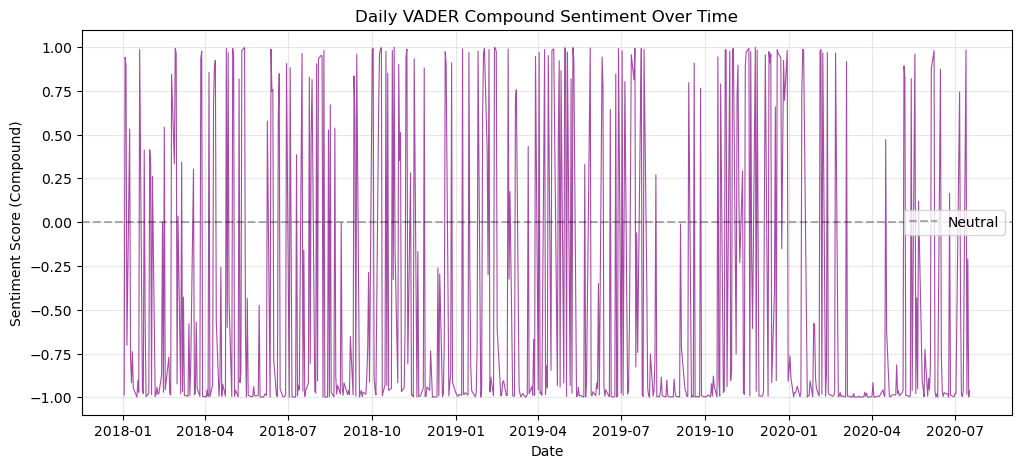

In [33]:
# Plot daily VADER compound sentiment
plt.figure(figsize=(12, 5))
plt.plot(features_df.index, features_df['vader_compound'], color='purple', alpha=0.7, linewidth=0.8)
plt.title("Daily VADER Compound Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (Compound)")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3, label='Neutral')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Observation:** Daily sentiment is very noisy with rapid fluctuations. Let's smooth it with a rolling average.

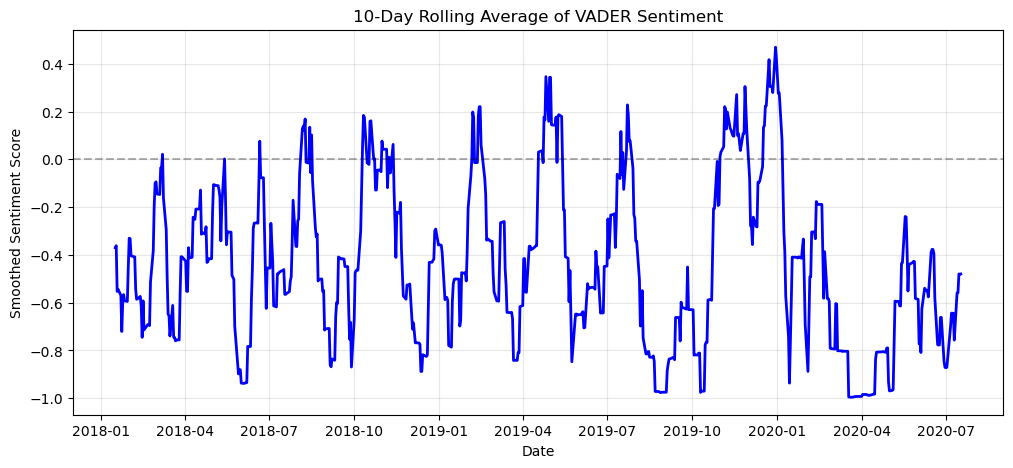

In [34]:
# Plot 10-day rolling average to see sentiment trends
plt.figure(figsize=(12, 5))
plt.plot(features_df['vader_compound'].rolling(10).mean(), color='blue', linewidth=2)
plt.title("10-Day Rolling Average of VADER Sentiment")
plt.xlabel("Date")
plt.ylabel("Smoothed Sentiment Score")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

**Observation:** The smoothed sentiment reveals meaningful news cycles - periods of sustained positive or negative news waves are now visible.

---

## Method 2: FinBERT Sentiment Analysis

**FinBERT** is a specialized BERT model fine-tuned specifically on financial text (earnings calls, analyst reports, financial news).

**Key differences from VADER:**
- Uses deep learning (transformer neural network) instead of rules
- Trained specifically on financial language and jargon
- May better capture subtle financial sentiment nuances

**Output scores:**
- `positive`: Probability the text expresses positive sentiment (0-1)
- `negative`: Probability the text expresses negative sentiment (0-1)
- `neutral`: Probability the text is neutral (0-1)
- All three probabilities sum to 1.0

In [35]:
# Load FinBERT model and tokenizer
print("Loading FinBERT model (this may take a moment)...")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Create pipeline for easy sentiment analysis
# Use GPU if available for faster processing
finbert_pipeline = pipeline(
    "sentiment-analysis",
    model=finbert_model,
    tokenizer=finbert_tokenizer,
    return_all_scores=True,  # Get probabilities for all three classes
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

print(f"FinBERT loaded successfully (using {'GPU' if torch.cuda.is_available() else 'CPU'})")

Loading FinBERT model (this may take a moment)...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

c:\Users\Owner\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Owner\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For bet

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


FinBERT loaded successfully (using CPU)


c:\Users\Owner\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [36]:
# Define function to get FinBERT scores
def finbert_scores(text):
    """
    Calculate FinBERT sentiment scores for text
    
    Args:
        text: Headline text to analyze
    
    Returns:
        Dict with 'positive', 'negative', and 'neutral' probabilities
    """
    try:
        # Truncate text to 512 tokens (FinBERT's max input length)
        scores = finbert_pipeline(text[:512])[0]
        # Convert list of dicts to dict with lowercase keys
        out = {d['label'].lower(): d['score'] for d in scores}
        return out
    except Exception as e:
        # Return neutral scores if processing fails
        return {"positive": 0, "negative": 0, "neutral": 1}

print("FinBERT scoring function defined")

FinBERT scoring function defined


In [37]:
# Apply FinBERT to all headlines
# WARNING: This takes ~5 minutes to process all days
print("Calculating FinBERT scores for all trading days...")
print("This may take 3-5 minutes depending on your hardware...")

finbert_dicts = features_df['headline_concat'].apply(finbert_scores)

print("FinBERT scoring complete!")

Calculating FinBERT scores for all trading days...
This may take 3-5 minutes depending on your hardware...
FinBERT scoring complete!
FinBERT scoring complete!


In [38]:
# Extract FinBERT scores into separate columns
features_df['finbert_positive'] = finbert_dicts.apply(lambda d: d['positive'])
features_df['finbert_negative'] = finbert_dicts.apply(lambda d: d['negative'])
features_df['finbert_neutral']  = finbert_dicts.apply(lambda d: d['neutral'])

print("FinBERT sentiment features added to dataset")

FinBERT sentiment features added to dataset


In [ ]:
# Preview FinBERT scores
print("Sample FinBERT sentiment scores:")
features_df[['headline_concat', 'finbert_positive', 'finbert_negative', 'finbert_neutral']].head(10)

,headline_concat,finbert_positive,finbert_negative,finbert_neutral
Date,,,,
2018-01-02,the guardian view on ryanair s model a union-f...,0.060696,0.037543,0.901761
2018-01-03,business live uk construction growth disappoin...,0.871260,0.043647,0.085093
2018-01-04,uk leaving single market for tpp could hit wor...,0.024769,0.917584,0.057646
2018-01-05,the guardian s audio long reads manchester cit...,0.667475,0.048278,0.284247
2018-01-08,business live wall street and ftse 100 hit new...,0.377619,0.535373,0.087008


### Visualize FinBERT Sentiment Over Time

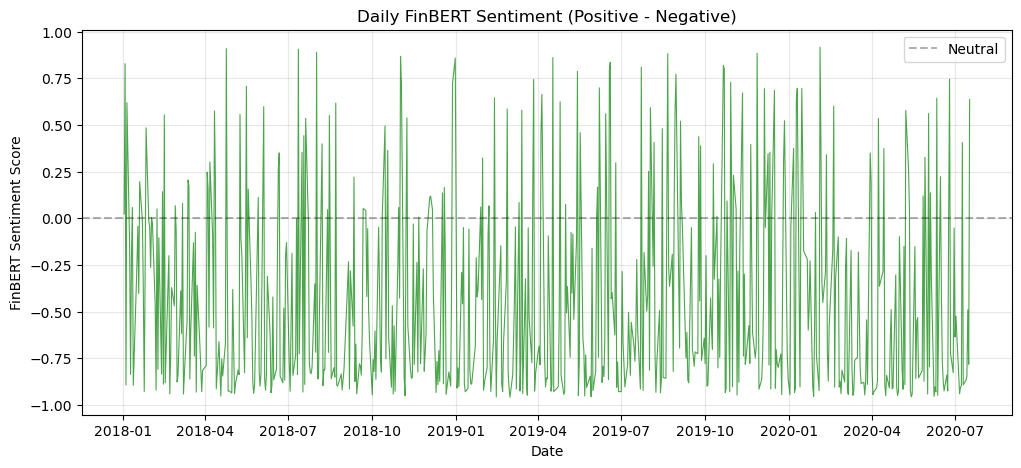

In [39]:
# Create a net sentiment signal (positive minus negative)
finbert_signal = features_df['finbert_positive'] - features_df['finbert_negative']

# Plot daily FinBERT sentiment
plt.figure(figsize=(12, 5))
plt.plot(features_df.index, finbert_signal, color='green', alpha=0.7, linewidth=0.8)
plt.title("Daily FinBERT Sentiment (Positive - Negative)")
plt.xlabel("Date")
plt.ylabel("FinBERT Sentiment Score")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3, label='Neutral')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Observation:** Daily FinBERT sentiment is also quite volatile. Let's smooth it.

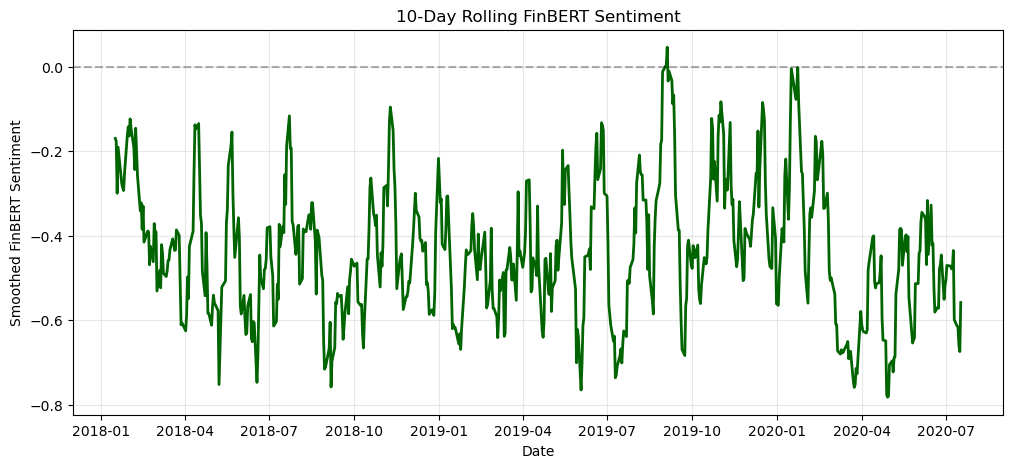

In [40]:
# Plot 10-day rolling average of FinBERT sentiment
plt.figure(figsize=(12, 5))
rolling_finbert = finbert_signal.rolling(10).mean()
plt.plot(rolling_finbert, color='darkgreen', linewidth=2)
plt.title("10-Day Rolling FinBERT Sentiment")
plt.xlabel("Date")
plt.ylabel("Smoothed FinBERT Sentiment")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

### Explore Sentiment vs Price Relationship

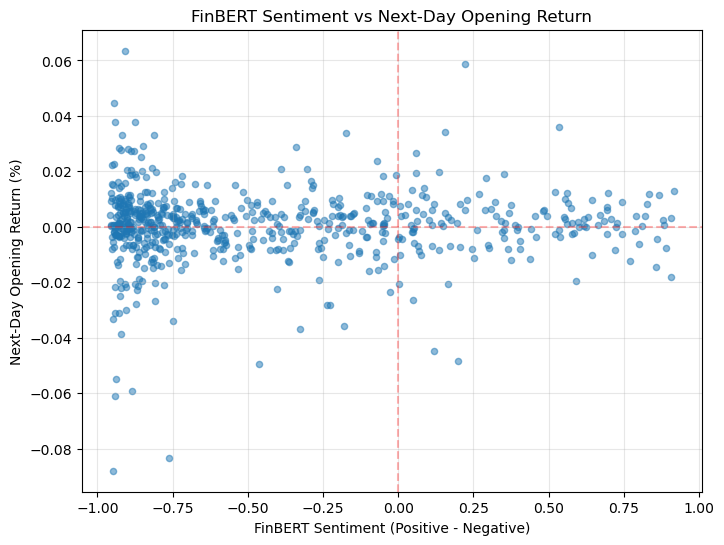

In [41]:
# Calculate next-day opening return for analysis
features_df["Next_Open_Return"] = (
    (features_df["Next_Open_SPY"] - features_df["Open_SPY"])
    / features_df["Open_SPY"]
)

# Scatter plot: FinBERT sentiment vs next-day return
plt.figure(figsize=(8, 6))
plt.scatter(
    finbert_signal,
    features_df["Next_Open_Return"],
    alpha=0.5,
    s=20
)
plt.title("FinBERT Sentiment vs Next-Day Opening Return")
plt.xlabel("FinBERT Sentiment (Positive - Negative)")
plt.ylabel("Next-Day Opening Return (%)")
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

**Key Observation:** No strong linear relationship between daily FinBERT sentiment and next-day returns. This suggests:
- Sentiment alone may not predict prices
- Combination with technical features may be more powerful
- Non-linear relationships may exist that require machine learning to discover

---

# Part 7: Final Dataset Preparation

## Clean and Export Modeling Dataset

In [42]:
# Create final dataset by removing text column and dropping missing values
final_df = features_df.copy()

# Drop the concatenated headline text (no longer needed after sentiment extraction)
drop_cols = ["headline_concat"]
final_df = final_df.drop(columns=drop_cols, errors="ignore")

# Drop rows with any missing values
# (These will be early rows affected by rolling windows and lags)
final_df = final_df.dropna()

print(f"Final dataset shape: {final_df.shape}")
print(f"Features: {final_df.shape[1]}, Samples: {final_df.shape[0]}")

Final dataset shape: (619, 45)
Features: 45, Samples: 619


In [43]:
# Verify no missing values remain
print("Missing values check:")
print(final_df.isna().sum().sum(), "total missing values")

# Display final feature list
print(f"\nFinal features ({len(final_df.columns)} total):")
print(list(final_df.columns))

Missing values check:
0 total missing values

Final features (45 total):
['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return', 'High_Low_Spread', 'Close_Open_Change', 'Close_to_High', 'Close_to_Low', 'Return_1', 'Return_2', 'Return_3', 'Return_5', 'Return_10', 'Momentum_3', 'Momentum_7', 'Close_lag1', 'Close_lag2', 'Close_lag3', 'MA_5', 'MA_20', 'Close_minus_MA_5', 'Close_minus_MA_20', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'TR', 'ATR_14', 'Prev_Day_Overnight_Return', 'day_of_week', 'month', 'day_of_month', 'week_of_month', 'is_month_end', 'is_quarter_end', 'Next_Open_SPY', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'finbert_positive', 'finbert_negative', 'finbert_neutral', 'Next_Open_Return']


In [44]:
# Save the final modeling dataset to CSV
output_filename = "final_modeling_dataset.csv"
final_df.to_csv(output_filename, index=True)

print(f"✓ Final dataset saved to: {output_filename}")
print(f"✓ Shape: {final_df.shape[0]} rows × {final_df.shape[1]} columns")
print(f"✓ Date range: {final_df.index.min().date()} to {final_df.index.max().date()}")

✓ Final dataset saved to: final_modeling_dataset.csv
✓ Shape: 619 rows × 45 columns
✓ Date range: 2018-01-31 to 2020-07-16


---

## Feature Correlation Analysis

Understanding which features correlate most strongly with our target (Next_Open_SPY) helps identify the most predictive variables.

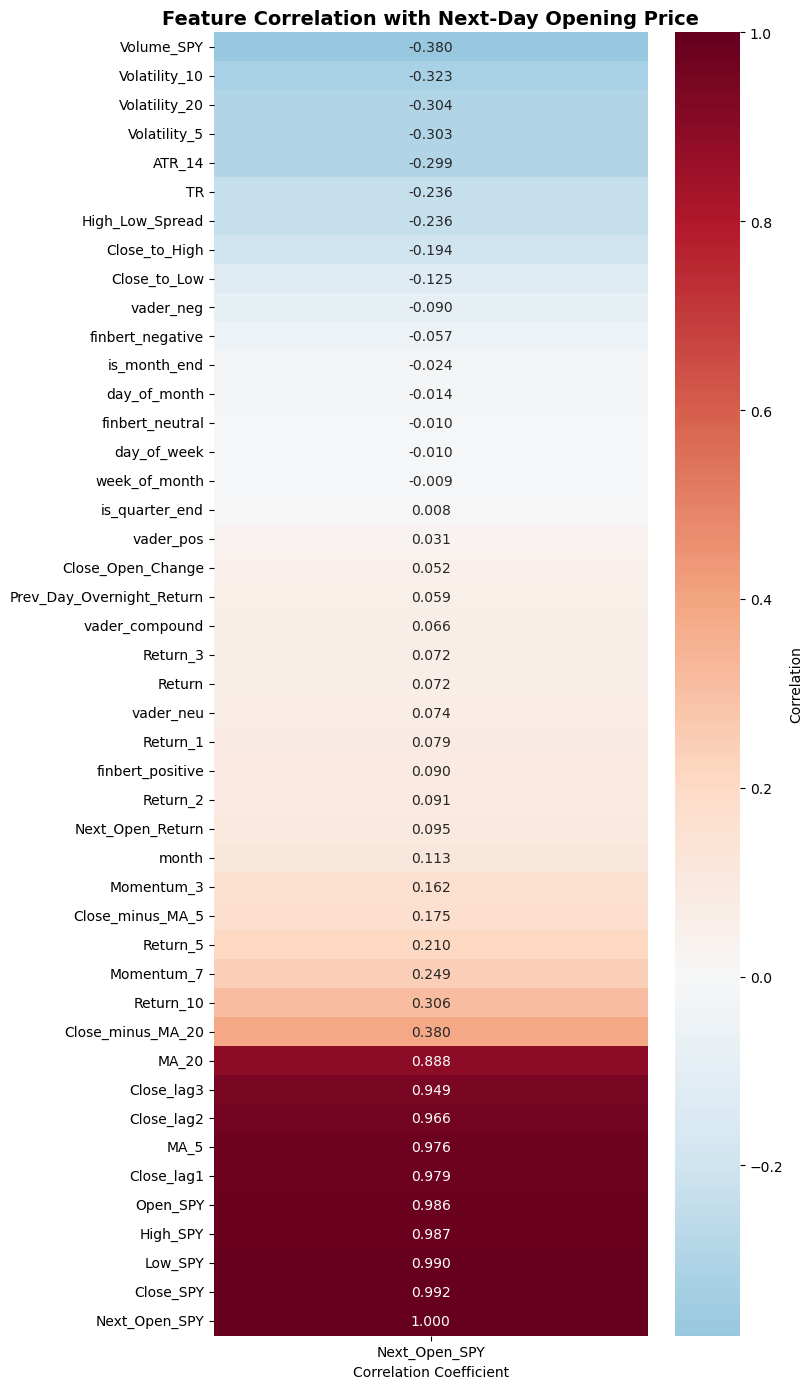


Top 10 Positively Correlated Features:
Close_minus_MA_20    0.380088
MA_20                0.887648
Close_lag3           0.949439
Close_lag2           0.965659
MA_5                 0.975878
Close_lag1           0.979233
Open_SPY             0.985884
High_SPY             0.986872
Low_SPY              0.989616
Close_SPY            0.991663
Name: Next_Open_SPY, dtype: float64

Top 10 Negatively Correlated Features:
Volume_SPY        -0.380346
Volatility_10     -0.323362
Volatility_20     -0.304329
Volatility_5      -0.302570
ATR_14            -0.299469
TR                -0.236139
High_Low_Spread   -0.236139
Close_to_High     -0.193859
Close_to_Low      -0.124695
vader_neg         -0.089677
Name: Next_Open_SPY, dtype: float64


In [45]:
# Calculate correlation of all features with target variable
target_corr = final_df.corr()["Next_Open_SPY"].sort_values(ascending=True)

# Visualize correlations with heatmap
plt.figure(figsize=(8, 14))
sns.heatmap(
    target_corr.to_frame(), 
    annot=True, 
    cmap='RdBu_r',  # Red for negative, Blue for positive
    center=0, 
    fmt='.3f',
    cbar_kws={'label': 'Correlation'}
)
plt.title("Feature Correlation with Next-Day Opening Price", fontsize=14, fontweight='bold')
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

# Print top correlations
print("\nTop 10 Positively Correlated Features:")
print(target_corr.tail(11)[:-1])  # Exclude target itself
print("\nTop 10 Negatively Correlated Features:")
print(target_corr.head(10))

In [ ]:
# Focus on sentiment feature correlations
sent_cols = ["vader_neg", "vader_neu", "vader_pos", "vader_compound",
             "finbert_positive", "finbert_negative", "finbert_neutral"]

print("Sentiment Feature Correlations with Next-Day Opening Price:")
sentiment_corr = final_df[sent_cols + ["Next_Open_SPY"]].corr()["Next_Open_SPY"].drop("Next_Open_SPY")
print(sentiment_corr.sort_values())

,vader_neg,vader_neu,vader_pos,vader_compound,finbert_positive,finbert_negative,finbert_neutral,Next_Open_SPY
vader_neg,1.000000,-0.333668,-0.109601,-0.546340,-0.089835,0.047232,0.023875,-0.089678
vader_neu,-0.333668,1.000000,-0.419689,-0.007695,-0.059806,0.077618,-0.051287,0.073736
vader_pos,-0.109601,-0.419689,1.000000,0.484424,0.137545,-0.103144,0.008297,0.031315
vader_compound,-0.546340,-0.007695,0.484424,1.000000,0.083539,-0.058738,-0.000645,0.066100
finbert_positive,-0.089835,-0.059806,0.137545,0.083539,1.000000,-0.726594,0.026426,0.089816
finbert_negative,0.047232,0.077618,-0.103144,-0.058738,-0.726594,1.000000,-0.706028,-0.056565
finbert_neutral,0.023875,-0.051287,0.008297,-0.000645,0.026426,-0.706028,1.000000,-0.010277
Next_Open_SPY,-0.089678,0.073736,0.031315,0.066100,0.089816,-0.056565,-0.010277,1.000000


**Key Findings:**
- **Sentiment features show weak linear correlation** with next-day opening price
- **Price-based features** (lagged prices, moving averages) show strongest correlations
- This doesn't mean sentiment is useless - machine learning models can discover non-linear relationships
- Combining sentiment with technical features may improve predictions

## Data Dictionary

**Index**

- `Date` (DatetimeIndex)  
  - Trading day for which features are computed.  
  - All price, technical, sentiment, and calendar features for this date are used to predict the *next* day's opening price (`Next_Open_SPY`).

---

### Price & Return Features

| Column         | Type  | Description |
|----------------|-------|-------------|
| `Open_SPY`     | float | Opening price of SPY on `Date`. |
| `High_SPY`     | float | Highest intraday price of SPY on `Date`. |
| `Low_SPY`      | float | Lowest intraday price of SPY on `Date`. |
| `Close_SPY`    | float | Closing price of SPY on `Date`. |
| `Volume_SPY`   | float | Trading volume for SPY on `Date`. |
| `Return`       | float | Daily close-to-close return: `(Close_SPY − Close_SPY.shift(1)) / Close_SPY.shift(1)`. |

---

### Technical / Engineered Price Features

| Column                | Type  | Description |
|-----------------------|-------|-------------|
| `High_Low_Spread`     | float | Intraday trading range: `High_SPY - Low_SPY`. |
| `Close_Open_Change`   | float | Intraday price change: `Close_SPY - Open_SPY`. |
| `Close_to_High`       | float | Distance from close to intraday high. |
| `Close_to_Low`        | float | Distance from close to intraday low. |
| `Return_1`            | float | Lagged 1-day return. |
| `Return_2`            | float | Lagged 2-day return. |
| `Return_3`            | float | Lagged 3-day return. |
| `Return_5`            | float | 5-day percentage return. |
| `Return_10`           | float | 10-day percentage return. |
| `Momentum_3`          | float | 3-day momentum: `Close_SPY / Close_SPY.shift(3) − 1`. |
| `Momentum_7`          | float | 7-day momentum. |
| `Close_lag1`          | float | Previous day close. |
| `Close_lag2`          | float | Close price 2 days ago. |
| `Close_lag3`          | float | Close price 3 days ago. |
| `MA_5`                | float | 5-day simple moving average of `Close_SPY`. |
| `MA_20`               | float | 20-day simple moving average of `Close_SPY`. |
| `Close_minus_MA_5`    | float | Distance from close to 5-day MA. |
| `Close_minus_MA_20`   | float | Distance from close to 20-day MA. |
| `Volatility_5`        | float | 5-day rolling standard deviation of `Return`. |
| `Volatility_10`       | float | 10-day rolling standard deviation of `Return`. |
| `Volatility_20`       | float | 20-day rolling standard deviation of `Return`. |
| `TR`                  | float | True Range: max of intraday and close-based ranges. |
| `ATR_14`              | float | 14-day Average True Range. |
| `Prev_Day_Overnight_Return` | float | Overnight return from previous close to today’s open. |

---

### Calendar / Seasonality Features

| Column            | Type | Description |
|-------------------|------|-------------|
| `day_of_week`     | int  | Day of week (0 = Monday, …, 4 = Friday). |
| `month`           | int  | Month of year (1–12). |
| `day_of_month`    | int  | Day of the month (1–31). |
| `week_of_month`   | int  | Week index within the month (0–4). |
| `is_month_end`    | int  | 1 if `Date` is the final trading day of the month, else 0. |
| `is_quarter_end`  | int  | 1 if `Date` is the final trading day of the quarter, else 0. |

---

### VADER Sentiment Features (Aggregated Headlines for `Date`)

| Column           | Type  | Description |
|------------------|-------|-------------|
| `vader_neg`      | float | Proportion of negative sentiment. |
| `vader_neu`      | float | Proportion of neutral sentiment. |
| `vader_pos`      | float | Proportion of positive sentiment. |
| `vader_compound` | float | Overall VADER sentiment score in \[-1, 1]. |

---

### FinBERT Sentiment Features (Aggregated Headlines for `Date`)

| Column              | Type  | Description |
|---------------------|-------|-------------|
| `finbert_positive`  | float | FinBERT-estimated probability that news is positive. |
| `finbert_negative`  | float | FinBERT-estimated probability that news is negative. |
| `finbert_neutral`   | float | FinBERT-estimated probability that news is neutral. |

---

### Target Variables

| Column             | Type  | Description |
|--------------------|-------|-------------|
| `Next_Open_SPY`    | float | **Next-day opening price** of SPY (prediction target). |
| `Next_Open_Return` | float | Next-day open return: `(Next_Open_SPY − Open_SPY) / Open_SPY`. Useful for EDA. |

